In [1]:
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
def connected_tuples(pairs):
    """
    Function for finding connected communities from a list of connected tuples
    
    Input: List of connected tuples
    Output: List of connected communities (similarity groups)
    """
    lists_by_element = {}

    def make_new_list_for(x, y):
        lists_by_element[x] = lists_by_element[y] = [x, y]

    def add_element_to_list(lst, el):
        lst.append(el)
        lists_by_element[el] = lst

    def merge_lists(lst1, lst2):
        merged_list = lst1 + lst2
        for el in merged_list:
            lists_by_element[el] = merged_list

    for x, y in pairs:
        xList = lists_by_element.get(x)
        yList = lists_by_element.get(y)

        if not xList and not yList:
            make_new_list_for(x, y)

        if xList and not yList:
            add_element_to_list(xList, y)

        if yList and not xList:
            add_element_to_list(yList, x)            

        if xList and yList and xList != yList:
            merge_lists(xList, yList)

    # return the unique lists present in the dictionary
    return set(tuple(l) for l in lists_by_element.values())

# Heterogeneous corpus analysis

This analysis uses a data set of approximately 2500 simulated documents.  Each simulated document was created from distinct combinations of multiple source documents, simulating a situation where all documents of a corpus are expected to be significantly dissimilar.

Out of this set of simulated documents, 15 were duplicated with a small number of targeted differences to create the target set of documents with unusually high similarity to another document.

In [3]:
# Simulated documents are in a folder - this collects their paths for loading
text_dir = "../data/final_data/bills/"
files = [file for file in os.listdir(text_dir) if file[-4:] == ".txt"]
print(f"There are {len(files)} files")

There are 2521 files


In [4]:
# count number of target docs based on target file naming convention
target_counter = 0
for file in files:
    if file[-6:] == '_2.txt':
        target_counter += 1
print(f"There are {target_counter} target docs")

There are 15 target docs


In [5]:
# Load documents, store as list of strings
text = []
for file in files:
    # ingest single text file
    with open(f"{text_dir}/{file}") as f:
        doc_text = f.read()
        text.append(doc_text)

In [6]:
# Vectorize documents
vectorizer = TfidfVectorizer(norm='l2', max_df=0.99)
X = vectorizer.fit_transform(text)

In [7]:
# Create doc adjacency matrix - equivalent to Cosine similarity when using l2 norm in TfidfVectorizer
data = X.dot(X.transpose())
print(f"document adjacency matrix shape: {data.shape}")

document adjacency matrix shape: (2521, 2521)


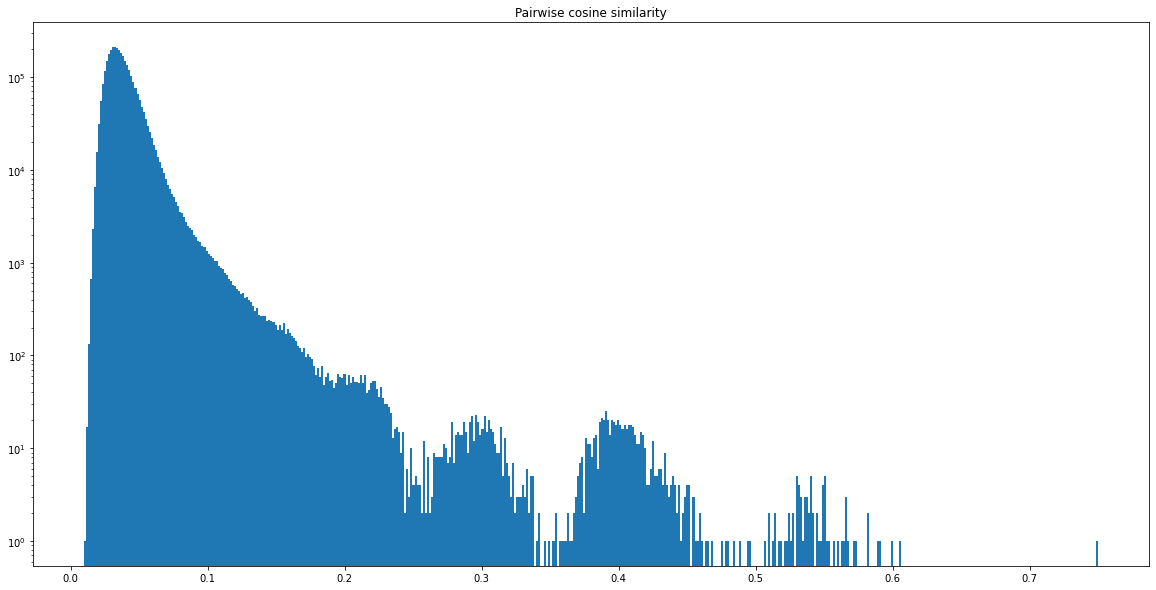

In [8]:
# Create histogram of cosine distances between all document pairs
# This helps in setting a threshold for identifying candidate document pairs

temp_array = data.toarray()
temp_array = np.triu(temp_array, k=1)
temp_array_elements = temp_array.flatten()
temp_array_elements = temp_array_elements[temp_array_elements > 0]

_ = plt.hist(temp_array_elements, bins=500)  # arguments are passed to np.histogram
plt.yscale('log')
plt.title("Pairwise cosine similarity")
plt.show()

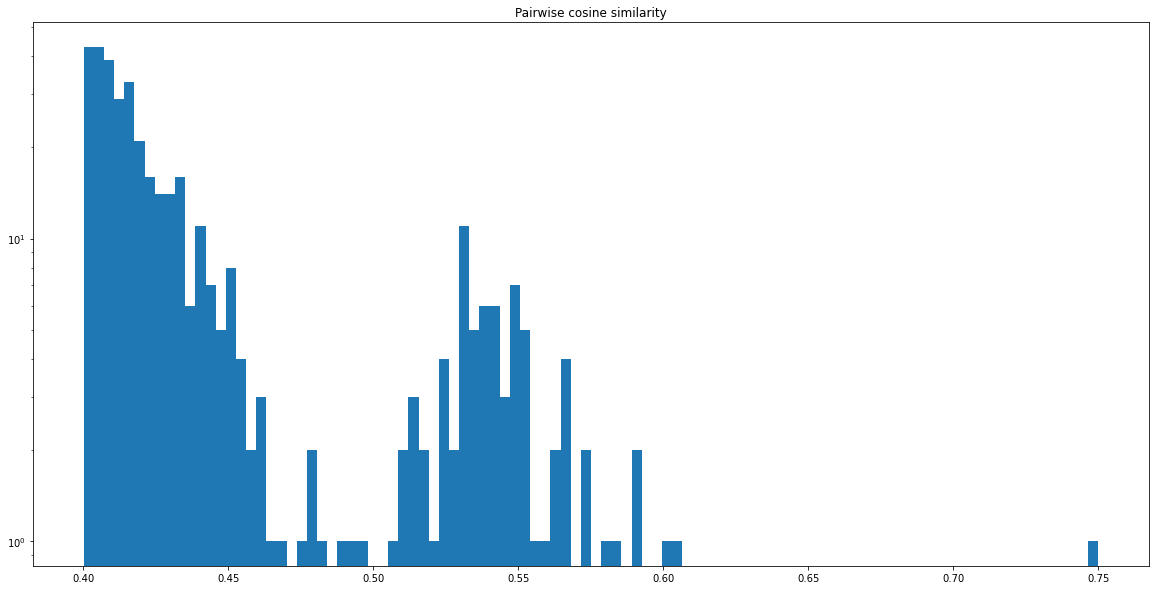

In [9]:
# Set lower threshold for cosine similarity for target documents, view resulting histogram
#
# Note: in a real world situation, we don't know which documents are target documents.
# Therefore, setting this threshold represents an assumption about how much similarity
# target docments ought to have, and how the cosine similarity distribution 
# might offer clues on an optimal threshold value.

threshold = 0.4
_ = plt.hist(temp_array_elements[temp_array_elements > threshold], bins=100)
plt.title("Pairwise cosine similarity")
plt.yscale('log')
plt.show()

In [10]:
# Using threshold, identify documents of interest from similarity matrix
temp_array = data.toarray()
np.fill_diagonal(temp_array, 0)
potential_doc_pairs = np.argwhere(temp_array >= threshold)

potential_docs = []
for item in potential_doc_pairs:
    potential_docs.append(item[0])
    
potential_docs = sorted(set(potential_docs))

print(f"{len(potential_docs)} potential documents of interest were discovered using a threshold of {threshold}\n_________________________________________")

target_doc_count = 0
target_docs = []
for potential_doc in potential_docs:
    if files[potential_doc][-6:] == '_2.txt':
        target_doc_count += 1
        target_docs.append(files[potential_doc])
print(f"\nThe following {target_doc_count} target documents were included:\n")
for target_doc in target_docs:
    print(target_doc)

72 potential documents of interest were discovered using a threshold of 0.4
_________________________________________

The following 15 target documents were included:

Alan_Bell-6-1380-3963_2.txt
Alexandra_Turner-8-1759-4090_2.txt
Alyssa_Welch-2-2236-0718_2.txt
Bianca_Cobb-1-2842-1993_2.txt
Bradley_Johnson-2-4763-9635_2.txt
Brooke_Mcfarland-4-5891-9335_2.txt
Carlos_Wong-1-8298-5922_2.txt
Chelsea_Cobb-4-9518-0841_2.txt
Cynthia_Murray-1-1683-7547_2.txt
Daniel_King-5-0701-0049 _2.txt
Darrell_Perkins_MD-6-3740-7487_2.txt
Elizabeth_Williams-2-4416-5310_2.txt
Frank_Gordon-1-4199-6510_2.txt
George_Fleming-8-7663-9881_2.txt
Heather_Carter-5-1444-7942_2.txt


In [11]:
# Compile list of detected clusters
clusters = connected_tuples(potential_doc_pairs)

clusters_files = []
for cluster in clusters:
    cluster_files = []
    for doc in cluster:
        cluster_files.append(files[doc])
    clusters_files.append(cluster_files)
clusters_files.sort(key=len)

for i, cluster in enumerate(clusters_files):
    print(f"***** Similarity Group {i+1} *****\n{cluster}\n\n")

***** Similarity Group 1 *****
['Alexandra_Turner-8-1759-4090.txt', 'Alexandra_Turner-8-1759-4090_2.txt']


***** Similarity Group 2 *****
['Bradley_Johnson-2-4763-9635.txt', 'Bradley_Johnson-2-4763-9635_2.txt']


***** Similarity Group 3 *****
['George_Fleming-8-7663-9881.txt', 'George_Fleming-8-7663-9881_2.txt']


***** Similarity Group 4 *****
['Alyssa_Welch-2-2236-0718.txt', 'Alyssa_Welch-2-2236-0718_2.txt']


***** Similarity Group 5 *****
['Bianca_Cobb-1-2842-1993.txt', 'Bianca_Cobb-1-2842-1993_2.txt']


***** Similarity Group 6 *****
['Brooke_Mcfarland-4-5891-9335.txt', 'Brooke_Mcfarland-4-5891-9335_2.txt']


***** Similarity Group 7 *****
['Carlos_Wong-1-8298-5922.txt', 'Carlos_Wong-1-8298-5922_2.txt']


***** Similarity Group 8 *****
['Daniel_King-5-0701-0049 _2.txt', 'Daniel_King-5-0701-0049.txt']


***** Similarity Group 9 *****
['Heather_Carter-5-1444-7942.txt', 'Heather_Carter-5-1444-7942_2.txt']


***** Similarity Group 10 *****
['Darrell_Perkins_MD-6-3740-7487.txt', 'Dar

# Homogeneous corpus analysis

This analysis uses a data set of approximately 2500 simulated documents.  Each simulated document was created from a single source document (a sample Pepco utility bill), simulating a situation where all documents of a corpus are expected to be significantly similar. 

Out of this set of simulated documents, 15 were duplicated with a small number of targeted differences to create the target set of documents with unusually high similarity to another document.

In [12]:
# Simulated documents are in a folder - this collects their paths for loading
text_dir = "../data/final_data/pepco_bills/"
files = [file for file in os.listdir(text_dir) if file[-4:] == ".txt"]
print(f"There are {len(files)} files")

There are 2515 files


In [13]:
# count number of target docs based on target file naming convention
target_counter = 0
for file in files:
    if (
        (file[-5:] == 'A.txt')
        | (file[-5:] == 'B.txt')
        | (file[-5:] == 'C.txt')
        | (file[-5:] == 'D.txt')
        | (file[-5:] == 'E.txt')
        | (file[-5:] == 'F.txt')
    ):
        target_counter += 1
print(f"There are {target_counter} target docs")

There are 15 target docs


In [14]:
# Load documents, store as list of strings
text = []
for file in files:
    # ingest single text file
    with open(f"{text_dir}/{file}") as f:
        doc_text = f.read()
        text.append(doc_text)

In [15]:
# Vectorize documents
vectorizer = TfidfVectorizer(norm='l2', max_df=0.99)
X = vectorizer.fit_transform(text)

In [16]:
# Create doc adjacency matrix - equivalent to Cosine similarity when using l2 norm in TfidfVectorizer
data = X.dot(X.transpose())
print(f"document adjacency matrix shape: {data.shape}")

document adjacency matrix shape: (2515, 2515)


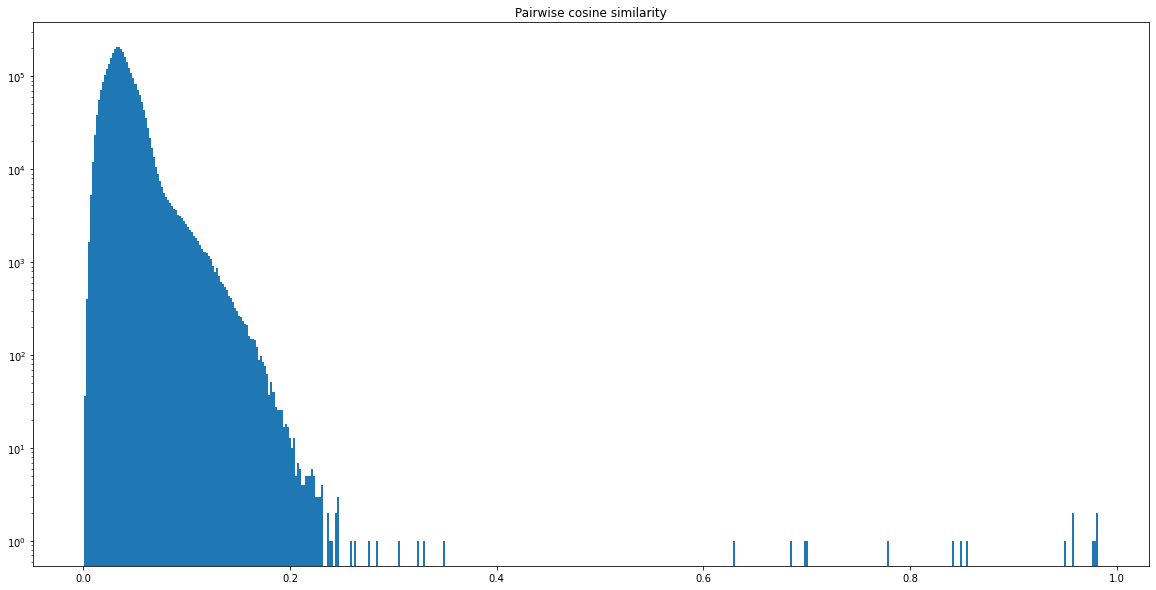

In [17]:
# Create histogram of cosine distances between all document pairs
# This helps in setting a threshold for identifying candidate document pairs

temp_array = data.toarray()
temp_array = np.triu(temp_array, k=1)
temp_array_elements = temp_array.flatten()
temp_array_elements = temp_array_elements[temp_array_elements > 0]

_ = plt.hist(temp_array_elements, bins=500)  # arguments are passed to np.histogram
plt.yscale('log')
plt.title("Pairwise cosine similarity")
plt.show()

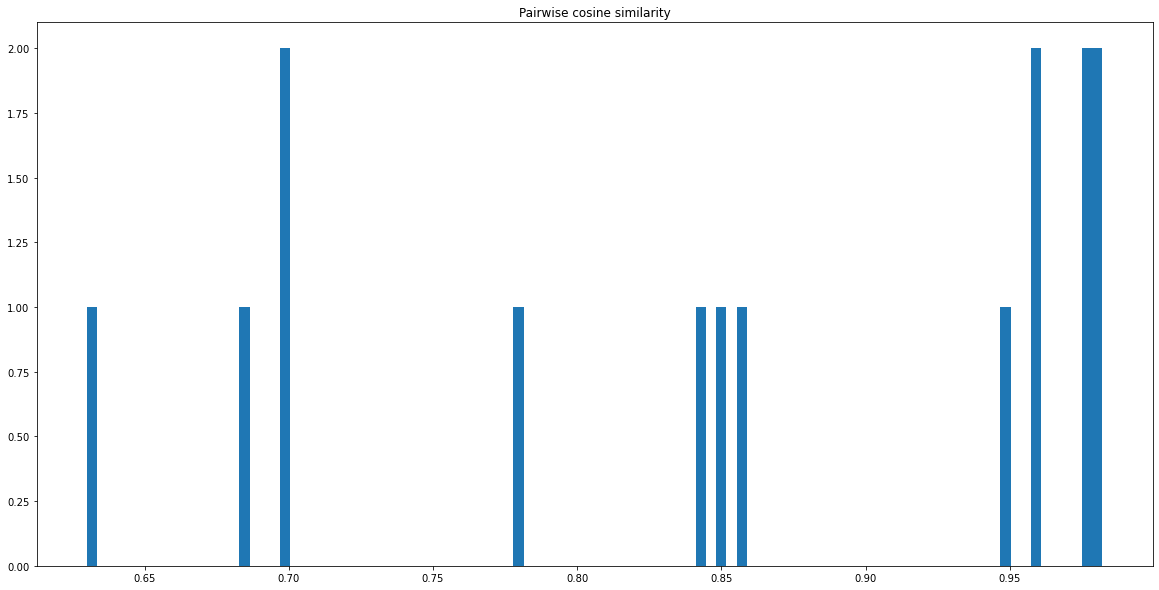

In [18]:
# Set lower threshold for cosine similarity for target documents, view resulting histogram
#
# Note: in a real world situation, we don't know which documents are target documents.
# Therefore, setting this threshold represents an assumption about how much similarity
# target docments ought to have, and how the cosine similarity distribution 
# might offer clues on an optimal threshold value.

threshold = 0.6
_ = plt.hist(temp_array_elements[temp_array_elements > threshold], bins=100)
plt.title("Pairwise cosine similarity")
#plt.yscale('log')
plt.show()

In [19]:
# Using threshold, identify documents of interest from similarity matrix
temp_array = data.toarray()
np.fill_diagonal(temp_array, 0)
potential_doc_pairs = np.argwhere(temp_array >= threshold)

potential_docs = []
for item in potential_doc_pairs:
    potential_docs.append(item[0])
    
potential_docs = sorted(set(potential_docs))

print(f"{len(potential_docs)} potential documents of interest were discovered using a threshold of {threshold}\n_________________________________________")

target_doc_count = 0
target_docs = []
for potential_doc in potential_docs:
    if (
        (files[potential_doc][-5:] == 'A.txt')
        | (files[potential_doc][-5:] == 'B.txt')
        | (files[potential_doc][-5:] == 'C.txt')
        | (files[potential_doc][-5:] == 'D.txt')
        | (files[potential_doc][-5:] == 'E.txt')
        | (files[potential_doc][-5:] == 'F.txt')
    ):
        target_doc_count += 1
        target_docs.append(files[potential_doc])
print(f"\nThe following {target_doc_count} potential documents were target documents:\n")
for target_doc in target_docs:
    print(target_doc)

30 potential documents of interest were discovered using a threshold of 0.6
_________________________________________

The following 15 potential documents were target documents:

Aaron_Wright-9-8329-8038_A.txt
Kristen_Sanchez-5-6336-6998_F.txt
Mark_Carter-3-1186-5497_B.txt
Mary_Robertson-2-6431-6188_F.txt
Michael_James-3-2217-0141_C.txt
Mr._Lance_Sullivan-8-0737-2346_F.txt
Phillip_Turner-7-0222-2716_D.txt
Renee_Sanchez-8-7432-1741_F.txt
Stacey_Smith-3-0393-2895_D.txt
Stephanie_Pham-5-2033-3910_C.txt
Tammy_Dillon-6-7389-3421_E.txt
Victoria_Cole-6-8186-1770_E.txt
William_Bryant-4-6878-9934_B.txt
William_Curry-2-0708-4364_F.txt
Zachary_Brady-3-0628-5093_A.txt


In [20]:
# Compile list of detected clusters
clusters = connected_tuples(potential_doc_pairs)

clusters_files = []
for cluster in clusters:
    cluster_files = []
    for doc in cluster:
        cluster_files.append(files[doc])
    clusters_files.append(cluster_files)
clusters_files.sort(key=len)

for i, cluster in enumerate(clusters_files):
    print(f"***** Similarity Group {i+1} *****\n{cluster}\n\n")

***** Similarity Group 1 *****
['Mr._Lance_Sullivan-8-0737-2346.txt', 'Mr._Lance_Sullivan-8-0737-2346_F.txt']


***** Similarity Group 2 *****
['Stacey_Smith-3-0393-2895.txt', 'Stacey_Smith-3-0393-2895_D.txt']


***** Similarity Group 3 *****
['Mary_Robertson-2-6431-6188.txt', 'Mary_Robertson-2-6431-6188_F.txt']


***** Similarity Group 4 *****
['Renee_Sanchez-8-7432-1741.txt', 'Renee_Sanchez-8-7432-1741_F.txt']


***** Similarity Group 5 *****
['Mark_Carter-3-1186-5497.txt', 'Mark_Carter-3-1186-5497_B.txt']


***** Similarity Group 6 *****
['Victoria_Cole-6-8186-1770.txt', 'Victoria_Cole-6-8186-1770_E.txt']


***** Similarity Group 7 *****
['Zachary_Brady-3-0628-5093.txt', 'Zachary_Brady-3-0628-5093_A.txt']


***** Similarity Group 8 *****
['William_Curry-2-0708-4364.txt', 'William_Curry-2-0708-4364_F.txt']


***** Similarity Group 9 *****
['Stephanie_Pham-5-2033-3910.txt', 'Stephanie_Pham-5-2033-3910_C.txt']


***** Similarity Group 10 *****
['Kristen_Sanchez-5-6336-6998.txt', 'Krist